# Includes

In [ ]:
! pip install git+https://github.com/rtqichen/torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
import time 
import pandas as pd
import numpy as np
from scipy import *
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos, cosh, tanh, real, imag
from numpy.linalg import inv, eig, pinv,norm
from scipy.linalg import svd, svdvals
import os
import matplotlib.pyplot as plt
from io import BytesIO
from functools import partial    
import scipy.io as sio 
import time  
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!unzip 'Dataset.zip'

# Data preprocessor

In [ ]:
def Normalize(train_data, eps=1e-12):
    """Standard Normalization of data"""
    return (train_data - train_data.mean(0, keepdims=True))/torch.sqrt(train_data.var(0, keepdims=True)+eps)

def NoRmalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = np.diag(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [ ]:
def load_data(path,name):
    """Load data from .mat file"""
    global  buses 
    PathName = os.path.join(path, name)
    data = sio.loadmat(PathName); 
    dV = data['bus_v']
    Y_ad = data['Y'] # 'Y' is the admittance matrix

    train_x = dV  
    return train_x, Y_ad

def load_all_data(Name):
    data, Adj = load_data(rootPath, Name)  
    return data, Adj

In [ ]:
# Creation of TRAIN and TEST datasets
n_classes = 87 
buses = 68

TEST = []

trainName ='Datasets/Training/Line_faults_train'
rootPath = ''# change to where the dataset is located
train_, A = load_all_data(trainName)
train_data = np.zeros((train_.shape[1], 2, train_.shape[0]))
train_data[:, 0] = np.real(np.array(train_)).T
train_data[:, 1] = np.imag(np.array(train_)).T
for j in range(1,3):
  fault_type = j # you can choose from 0 - 3: 
                                          #0 is three phase short circuit; 
                                          #1 is line to ground (LG); 
                                          #2 is double line to ground (DLG); 
                                          #3 is line to line (LL) faults.
  if (j == 0):
    k = [0, 1]
  else:
    k = [1,2,3,4,5]
  for p in k:
    impe_type = p# If you choose fault_type from 1 to 3, the impe_type is in the range of 1 to 5, representing different impedance; 
                # If you choose fault_type = 0, the impe-type is 1 to 2, representing different initial conditions;   
    testName = 'Datasets/Testing/Line_faults_test' +'_type_' + str(fault_type) + '_'+str(impe_type) 

    test, _ = load_all_data(testName)
    if len(TEST)==0:
      test_ = test.copy()
    Test = np.zeros((test.shape[1], 2, test.shape[0]))
    Test[:, 0] = np.real(np.array(test)).T#reshape(-1, buses)
    Test[:, 1] = np.imag(np.array(test)).T#reshape(-1, buses)
    #Test = np.zeros((test.shape[1], 1, test.shape[0]))
    #Test[:, 0] = np.array(test.real).T
    TEST.append(Test[:,:,:-1])

In [ ]:
def toPhase(Volt):
    """Return phase of a complex vector"""
    return torch.atan2(Volt[:, 1], (Volt[:, 0]+1e-14)).reshape(-1,1,Volt.shape[-1]), torch.sqrt(Volt[:, 1]**2+Volt[:, 0]**2).reshape(-1,1,Volt.shape[-1])
def toVolt(Ampl, Phase):
    """Return a complex vector given amplitude and phase"""
    return torch.cat((Ampl*torch.cos(Phase), Ampl*torch.sin(Phase)), dim=1)

In [ ]:
def data_prepare(x_in, x, n):
  """Creation of time-series data:
      - x_in: Input into the model
      - x: desired ouptut
      - n: time lag 
  """
  y = torch.zeros(x.shape[0], 2, x.shape[2])
  x_copy = torch.zeros(x_in.shape[0]+n, x_in.shape[1], x_in.shape[2])
  x_copy[0:n] = x_in[0]
  x_copy[n:] = x_in[0:x.shape[0]]
  y[-1] = x[-1]
  y[:-1] = x[1:]

  return x_in, y

In [ ]:
# Adjacency matrix for the GCNN
A = torch.FloatTensor(NoRmalize(abs(A).toarray() + np.eye(A.shape[0])))

In [ ]:
# Dynamical data for the training and testing
X_train_dynamic, y_train_dynamic = data_prepare(torch.FloatTensor(TEST[0]), torch.FloatTensor(TEST[0]), 1)
X_test_dynamic, y_test_dynamic = data_prepare(torch.FloatTensor(TEST[1]), torch.FloatTensor(TEST[1]), 1)

np.random.shuffle(TEST)
X_train_dynamic, y_train_dynamic = data_prepare(torch.FloatTensor(TEST[-1]), torch.FloatTensor(TEST[-1]), 1)
X_test_dynamic, y_test_dynamic = data_prepare(torch.FloatTensor(TEST[0]), torch.FloatTensor(TEST[0]), 1)
for i in range(1, int(len(TEST)/5)):
  X_test_dynamic = torch.cat((X_test_dynamic, torch.FloatTensor(TEST[i])))
  y_test_dynamic = torch.cat((y_test_dynamic, data_prepare(torch.FloatTensor(TEST[i]), torch.FloatTensor(TEST[i]),1)[1]))
for i in range(int(len(TEST)/5), len(TEST)-1):
  X_train_dynamic = torch.cat((X_train_dynamic, torch.FloatTensor(TEST[i])))
  y_train_dynamic = torch.cat((y_train_dynamic, data_prepare(torch.FloatTensor(TEST[i]), torch.FloatTensor(TEST[i]),1)[1]))

In [ ]:
n_classes = 87 
buses = 68
coef = 0.8 # observability coef
a = arange(buses)
np.random.shuffle(a)
w=[i for i in sorted(a[:int((1-coef)*(buses-1))])];
X_train_dynamic = X_train_dynamic[:,:,w]
X_test_dynamic = X_test_dynamic[:,:,w]

# Models

## Linear regression

In [ ]:
class LR(nn.Module):
    def __init__(self, nin, nout):
        super(LR, self).__init__()
        self.LR = nn.Linear(nin, nout)
        
    def forward(self, x):
        x = self.LR(x)
        return x

## Feed Forward NN

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, nin, nhid, nout):
        super(FeedForward, self).__init__()
        self.NN = nn.Sequential(nn.Linear(nin, nhid), nn.ReLU(), nn.Linear(nhid, nout))
        
    def forward(self, x):
        #x = torch.flatten(x, 1)
        x = self.NN(x)
        return x

In [ ]:
class NNet(nn.Module):
    def __init__(self, nin, nhid, nout):
        super(NNet, self).__init__()
        self.NN = nn.Sequential(nn.Linear(nin, nhid), nn.ReLU(), nn.Linear(nhid, nhid),nn.ReLU(), nn.Linear(nhid, nhid), nn.ReLU(), nn.Linear(nhid, nhid), nn.ReLU(), nn.Linear(nhid, nout))
        
    def forward(self, x):
        x = self.NN(x)
        return x

## AlexNet

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, outdim):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(8, 16, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(16, 16, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(16, 16, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32, 2*outdim),
        )

    def forward(self, x):
        batch = x.shape[0]
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = x.reshape(batch, 2, -1)
        return x

## GCNN

In [ ]:
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, adj, bias=True):
        super(GraphConvolution, self).__init__()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.in_features = in_features
        self.out_features = out_features
        self.adj = adj.to(device)
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        #self.weight = Parameter(torch.eye(out_features, in_features, dtype=torch.float32)/100)
        
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        support = torch.einsum('zx,iyx->izy', (self.adj, input))
        #print(support.shape)
        output = torch.einsum('xz,izy->ixy', (self.weight, support))
        output = output.permute(0, 2, 1)
        return output

class GCNN(nn.Module):
    def __init__(self, nin, nhid, nout, adj, dropout):
        super(GCNN, self).__init__()

        self.gc1 = GraphConvolution(nin, nhid, adj)
        self.classifier = nn.Sequential(
            nn.Linear(nhid, nout),
        )
        self.dropout = dropout
        #self.bn = nn.BatchNorm1d(nhid, affine=False)
    def forward(self, x):
        x = F.relu(self.gc1(x))
        x = F.dropout(x, self.dropout, training=self.training)
        #x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## ODE NN

In [ ]:
class GCDEFunc(nn.Module):
    def __init__(self, input_dim:int, hidden_dim:int, adj, type):#, dropout:float):
        """Standard GCDN ODE function class. To be passed to an ODEBlock"""
        super().__init__()
        if type == 'Graph':
          self.l = GraphConvolution(input_dim, hidden_dim, adj)
        if type == 'Linear':
          self.l = nn.Linear(input_dim, hidden_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        x = self.l(x)
        return x

import torch
import torch.nn as nn
import torchdiffeq

class ODEBlock(nn.Module):
    def __init__(self, odefunc:nn.Module, method:str='dopri5', rtol:float=1e-3, atol:float=1e-4, adjoint:bool=True):
        """ Standard ODEBlock class. Can handle all types of ODE functions
            :method:str = {'euler', 'rk4', 'dopri5', 'adams'}
        """
        super().__init__()
        self.odefunc = odefunc
        self.method = method
        self.adjoint_flag = adjoint
        self.atol, self.rtol = atol, rtol

    def forward(self, x:torch.Tensor, T:int=1):
        self.integration_time = torch.tensor([0, T]).float()
        self.integration_time = self.integration_time.type_as(x)

        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, self.integration_time,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                     rtol=self.rtol, atol=self.atol, method=self.method)
        return out[-1]
    
    def forward_batched(self, x:torch.Tensor, nn:int, indices:list, timestamps:set):
        """ Modified forward for ODE batches with different integration times """
        timestamps = torch.Tensor(list(timestamps))
        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, timestamps,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, timestamps,
                                     rtol=self.rtol, atol=self.atol, method=self.method)

        out = self._build_batch(out, nn, indices).reshape(x.shape)
        return out
    
    def _build_batch(self, odeout, nn, indices):
        b_out = []
        for i in range(len(indices)):
            b_out.append(odeout[indices[i],i*nn:(i+1)*nn])
        return torch.cat(b_out).to(odeout.device)
              
        
    def trajectory(self, x:torch.Tensor, T:int, num_points:int):
        self.integration_time = torch.linspace(0, t_end, num_points)
        self.integration_time = self.integration_time.type_as(x)
        out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                 rtol=self.rtol, atol=self.atol, method=self.method)
        return out

## PINN

In [ ]:
class PhysicsInformedNN(nn.Module):
    def __init__(self, nin, nhid, nout):
        super(PhysicsInformedNN, self).__init__()

        self.D = nn.Parameter(torch.rand((nout), dtype=torch.float32, requires_grad=True))
        self.P = nn.Parameter(torch.rand((nout), dtype=torch.float32, requires_grad=True))
        self.Nu = nn.Parameter(torch.rand((nout), dtype=torch.float32, requires_grad=True))

        self.EncLin1 = nn.Linear(nin, nhid)
        self.EncLin2 = nn.Linear(nhid, nout)

    def net_f(self, x):
        u = self.forward(x)
        u_t = data_prepare_dev(u)
        u_tt = data_prepare_dev(u_t)
        f = u_tt + self.D*u_t + self.Nu*u - self.P

        return f, u

    def forward(self, x):
        x = torch.relu(self.EncLin1(x))
        x = self.EncLin2(x)
        return x

## Hamiltonian NN

In [ ]:
def data_prepare_dev(x_in):
  """Approximation of the derivative of the input for physical models"""
  x_out = torch.zeros_like(x_in)
  for i in range(1, x_in.shape[0]):
      x_out[i] = x_in[i]-x_in[i-1]
  return x_out

In [ ]:
class Hamiltonian(nn.Module):
    def __init__(self, input_dim:int, hidden_dim:int, adj):
        super().__init__()
        self.input_dim = input_dim
        self.g1 = nn.Linear(int(input_dim/2), int(input_dim/2))
        self.g2 = nn.Linear(int(input_dim/2), int(input_dim/2))
        self.D = nn.Linear(input_dim, input_dim)
        self.L = nn.Linear(int(input_dim/2), int(input_dim/2))
        self.L.weight.data.fill_(0.0)
        self.L.weight.data += torch.eye((int(self.input_dim/2)), dtype=torch.float32, requires_grad=True)
        self.V1 = nn.Linear(int(input_dim/2), int(input_dim/2))
        self.V2 = nn.Linear(int(input_dim/2), 1)
        self.oper = nn.ReLU()
        self.nfe = 0
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def forward(self, t, x):
        with torch.enable_grad():
            one = torch.tensor(1, dtype=torch.float32, device=self.device, requires_grad=True)
            x = one * x
            self.nfe += 1
            q, dev_q = torch.chunk(x, 2, dim=-1)
            g = self.g2(F.relu(self.g1(q)))
            H = self.V2(F.relu(self.V1(q))) + torch.sum(torch.pow(torch.matmul(dev_q, self.L.weight.t()), 2)) / 2.0 
            H = H.reshape(-1,)
            M = torch.matmul(self.L.weight, self.L.weight.t()) + 1e-14*torch.eye((int(self.input_dim/2)), dtype=torch.float32, device=self.device)
            
            dH_q = torch.autograd.grad(H, q, grad_outputs=torch.ones_like(H), create_graph=True)[0]
            D_q, D_p = torch.chunk(self.D(torch.cat((dH_q, dev_q), dim=-1)), 2, dim=-1)
            out = torch.cat((dev_q-D_q, torch.matmul(-dH_q-D_p+g, M.inverse())), dim=-1).view_as(x)
        return out

## DIRODENN

In [ ]:
class ODE_Physics(nn.Module):
    def __init__(self, nout):
        super(ODE_Physics, self).__init__()
        self.D = nn.Parameter(torch.rand((nout), dtype=torch.float32, requires_grad=True))
        self.P = nn.Parameter(torch.rand((nout), dtype=torch.float32, requires_grad=True))
        self.g = nn.Parameter(torch.rand((nout), dtype=torch.float32, requires_grad=True))    
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        q, dq = torch.chunk(x, 2, dim=-1) 
        phase_q, ampl_q = toPhase(q)
        phase_dq, ampl_dq = toPhase(dq)
        phase_ddq = -torch.abs(self.D)*phase_dq - torch.sum(torch.abs(self.g)*(phase_q-phase_q.permute(0,2,1)), dim=1, keepdim=True) - self.P
        return torch.cat((toVolt(ampl_q, phase_dq), toVolt(ampl_dq, phase_ddq)), dim=-1)

# Train functions and Plot



In [ ]:
def train(net, X_train, y_train, X_test, y_test, batch_shape, lr=1.0e-3, optim = 'Adam', weight_decay=3e-7, Epoch = 50):
    """Train function for LR, FFNN, AlexNet, GCNN"""
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    if optim == 'RMSprop':
        optimizer = torch.optim.RMSprop(net.parameters(), lr=lr, alpha=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.9)
    batch_size = batch_shape

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(Epoch):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
        #for start_index in range(0, len(X_train)):
            optimizer.zero_grad()
            net.train()
            
            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            scheduler.step()

        net.eval()
        test_preds = net.forward(X_test)
        loss_ = loss(test_preds, y_test).data.cpu()
        test_loss_history.append(loss_)
        test_accuracy_history.append(Accuracy(y_test, test_preds-y_test))
        print(test_accuracy_history[-1])
    del net
    return test_loss_history, test_accuracy_history

In [ ]:
def train_HNN(net, X_train, y_train, X_test, y_test, batch_shape, lr=1.0e-3, optim = 'Adam', weight_decay=3e-8,Epoch = 50):
    """Train function for HNN"""
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    if optim == 'RMSprop':
        optimizer = torch.optim.RMSprop(net.parameters(), lr=lr, alpha=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    batch_size = batch_shape

    test_accuracy_history = []
    test_loss_history = []
    
    X_test = torch.cat((X_test.to(device), data_prepare_dev(X_test.to(device))), dim=-1)
    y_test = torch.cat((y_test.to(device), data_prepare_dev(y_test.to(device))), dim=-1)
    for epoch in range(Epoch):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            
            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = torch.cat((X_train[batch_indexes].to(device), data_prepare_dev(X_train[batch_indexes].to(device))), dim=-1)
            y_batch = torch.cat((y_train[batch_indexes].to(device), data_prepare_dev(y_train[batch_indexes].to(device))),dim=-1)

            preds = net(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            scheduler.step()
            
        net.eval()
        test_preds = net(X_test)
        loss_ = loss(test_preds, y_test).data.cpu()
        test_loss_history.append(loss_)
        
        test_accuracy_history.append(Accuracy(y_test, torch.chunk(test_preds-y_test, 2, dim=-1)[0]))
        print(loss_, test_accuracy_history[-1], Accuracy(y_test, test_preds-y_test))#, Accuracy(X_test, torch.chunk(test_preds_solution, 2, dim=-1)[0]-x_test[:, 0]))
    del net
    return test_loss_history, test_accuracy_history

In [ ]:
def train_PINN(net, X_train, y_train, X_test, y_test, batch_shape, lr, weight_decay=3e-8, Epoch = 50):
    """Train function for PINN"""
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    batch_size = batch_shape

    loss = torch.nn.MSELoss().to(device)

    test_loss_history = []
    test_accuracy = []

    X_test_f = X_test.to(device)
    y_test = y_test.to(device)
    for epoch in range(Epoch):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            
            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = Variable(X_train[batch_indexes], requires_grad=True).to(device)
            f_pred, u_pred= net.net_f(X_batch)
            loss_ = 100*loss(u_pred, y_train[batch_indexes].to(device)) + loss(f_pred, torch.zeros_like(f_pred))
            loss_.backward()

            optimizer.step()
            scheduler.step()

        net.eval()
        
        u_pred = net(X_test_f)
        Loss = loss(u_pred, y_test).data.cpu()
        test_loss_history.append(Loss)
        test_accuracy.append(Accuracy(y_test, y_test-u_pred))
        print(Loss, test_accuracy[-1], print(f_pred.norm()))

    del net
    return test_loss_history, test_accuracy

In [ ]:
def train_ODE(net, X_train, y_train, X_test, y_test, batch_shape, lr=1.0e-3, optim = 'Adam', weight_decay=3e-8, Epoch = 50):
    """Train function for Lin ODE, Graph ODE, DIRODENN"""
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=weight_decay)
    if optim == 'RMSprop':
        optimizer = torch.optim.RMSprop(net.parameters(), lr=lr, alpha=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    batch_size = batch_shape

    test_accuracy_history = []
    test_loss_history = []
    
    X_test = torch.cat((X_test.to(device), data_prepare_dev(X_test.to(device))), dim=-1)
    y_test = torch.cat((y_test.to(device), data_prepare_dev(y_test.to(device))), dim=-1)
    for epoch in range(Epoch):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            
            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = torch.cat((X_train[batch_indexes].to(device), data_prepare_dev(X_train[batch_indexes].to(device))), dim=-1)
            y_batch = torch.cat((y_train[batch_indexes].to(device), data_prepare_dev(y_train[batch_indexes].to(device))),dim=-1)
            preds = net(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            scheduler.step()

        net.eval()
        test_preds = net(X_test)
        loss_ = loss(test_preds, y_test).data.cpu()
        test_loss_history.append(loss_)
        
        test_accuracy_history.append(Accuracy(y_test, torch.chunk(test_preds-y_test, 2, dim=-1)[0]))
        torch.cuda.empty_cache()
        print(loss_, test_accuracy_history[-1], Accuracy(y_test, test_preds-y_test))
    del net
    return test_loss_history, test_accuracy_history

In [ ]:
from matplotlib.pyplot import figure
def acc_loss_graph(accuracies, losses, net_list, observ, Noise, save_file_name='plot.png', download=False):
    """Plot function for graphs of losses"""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(6)
    fig.set_figwidth(8)
    fig.suptitle('Observ = '+str(observ)+ '$\%$, Noise = ' + str(Noise)+'$\%$')
    fig.subplots_adjust(bottom=0.5)
    
    for experiment_id in net_list:
        ax1.plot(accuracies[experiment_id], label=experiment_id)
    ax1.legend()
    ax1.grid()
    ax1.set_title(' ')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy, dBs')
    fig.tight_layout()

    for experiment_id in net_list:

        ax2.plot(losses[experiment_id], label=experiment_id)
    ax2.legend()
    ax2.grid()
    ax2.set_title(' ');
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss, NMSE')
    fig.tight_layout()

def Accuracy(X, E):
    return 10*torch.log10((E.norm(dim=1)**2).sum()/(X.norm(dim=1)**2).sum())

# Main

In [ ]:
losses = {}
accuracy = {}
Time = {}
LinReg = LR(X_train_dynamic.shape[-1], buses)
t0 = time.time()
losses['LR'], accuracy['LR'] = train(LinReg, X_train_dynamic, y_train_dynamic, X_test_dynamic, y_test_dynamic, 199, lr=0.01, Epoch=1000)
Time['LR'] = (time.time() - t0)/1000
print ('Trainning of LR is DONE')

In [ ]:
graph_NN = GCNN(buses, 32, buses, A[:,w], 0.0)
t0 = time.time()
losses['GCNN'], accuracy['GCNN'] = train(graph_NN, X_train_dynamic, y_train_dynamic, X_test_dynamic , y_test_dynamic, 199, lr=0.01, weight_decay=5e-6, Epoch=1000)
Time['GCNN'] = (time.time() - t0)/1000
print ('Trainning of GCNN is DONE')

In [ ]:
FFNN = FeedForward(X_train_dynamic.shape[-1], 32, buses)
t0 = time.time()
losses['FFNN'], accuracy['FFNN'] = train(FFNN, X_train_dynamic, y_train_dynamic, X_test_dynamic , y_test_dynamic, 199, lr=0.02, weight_decay=5e-7, Epoch=1000)
Time['FFNN'] = (time.time() - t0)/1000
print ('Trainning of FFNN is DONE')

In [ ]:
gdefunc = GCDEFunc(input_dim=X_train_dynamic.shape[-1], hidden_dim=X_train_dynamic.shape[-1], adj=A[:,w], type='Linear')
gde = ODEBlock(odefunc=gdefunc)
LinODE = nn.Sequential(gde, nn.Linear(X_train_dynamic.shape[-1], buses))
t0 = time.time()
losses['ODE_Lin'], accuracy['ODE_Lin'] = train(LinODE, X_train_dynamic, y_train_dynamic, X_test_dynamic, y_test_dynamic, 199, 0.05, weight_decay=5e-8, Epoch=1000)
Time['ODE_Lin'] = (time.time() - t0)/1000
print ('Trainning of ODE_Lin NN is DONE')

In [ ]:
gdefunc = GCDEFunc(input_dim=buses, hidden_dim=X_train_dynamic.shape[-1], adj=A[:, w], type='Graph')#, dropout=0.1)
gde = ODEBlock(odefunc=gdefunc)
m = nn.Sequential(gde, nn.Linear(X_train_dynamic.shape[-1], buses))
t0 = time.time()
losses['ODE_Graph'], accuracy['ODE_Graph'] = train(m, X_train_dynamic, y_train_dynamic, X_test_dynamic, y_test_dynamic, 199, 0.05, weight_decay=5e-9, Epoch=1000)
Time['ODE_Graph'] = (time.time() - t0)/1000
print ('Trainning of ODE NN is DONE')#lamd=3e-6

In [ ]:
model = PhysicsInformedNN(X_train_dynamic.shape[-1], 32, buses)
t0 = time.time()
losses['PINN'], accuracy['PINN'] = train_PINN(model, X_train_dynamic, y_train_dynamic, X_test_dynamic, y_test_dynamic, 199, lr=0.005, weight_decay=8e-5, Epoch=1000)
Time['PINN'] = (time.time() - t0)/1000
print ('Trainning of PhysicsInformedNN is DONE')

In [ ]:
gdefunc = Hamiltonian(2*X_train_dynamic.shape[-1], 2*buses, A)
gde = ODEBlock(odefunc=gdefunc)
HNN = nn.Sequential(gde, nn.Linear(2*X_train_dynamic.shape[-1], 2*buses))
t0 = time.time()
losses['HNN'], accuracy['HNN'] = train_HNN(HNN, X_train_dynamic, y_train_dynamic, X_test_dynamic, y_test_dynamic, 199, 0.003, weight_decay=0, Epoch=1000)
Time['HNN'] = (time.time() - t0)/1000
print ('Trainning of HNN is DONE')

In [ ]:
gdefunc = ODE_Physics(X_train_dynamic.shape[-1])
gde = ODEBlock(odefunc=gdefunc)
DIRODENN = nn.Sequential(gde, nn.Linear(2*X_train_dynamic.shape[-1], 2*buses))
t0 = time.time()
losses['DIRODENN'], accuracy['DIRODENN'] = train_ODE(DIRODENN, X_train_dynamic, y_train_dynamic, X_test_dynamic, y_test_dynamic, 199, lr=5e-2, weight_decay=1e-8, Epoch = 1000)
Time['DIRODENN'] = (time.time() - t0)/1000
print ('Trainning of DIRECT ODE NN is DONE')

In [ ]:
model_name = 'LR'
mi = 0
for i in range(len(accuracy[model_name])):
    if accuracy[model_name][i].data < mi :
        mi = accuracy[model_name][i].data
mi

tensor(-21.4104)

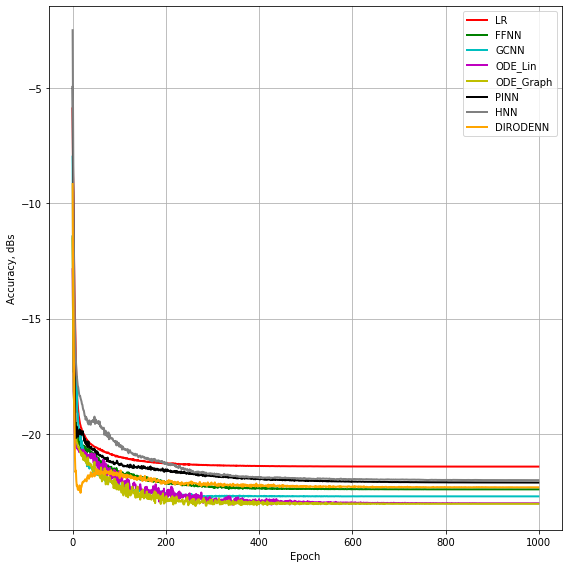

In [ ]:
Model_list = ['LR', 'FFNN' ,'GCNN', 'ODE_Lin', 'ODE_Graph', 'PINN', 'HNN', 'DIRODENN']
Color_list = ['r', 'g', 'c', 'm', 'y', 'k', 'gray', 'orange']
plt.figure(figsize=(8,8))
plt.grid()
for model_name, color in zip(Model_list, Color_list):
    plt.plot(torch.arange(len(accuracy[model_name])), accuracy[model_name], color , lw = 2, label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy, dBs')
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Diploma/dynamic/20_0/graph.png', dpi=200)
plt.show()

In [ ]:
torch.save(accuracy, '/content/drive/My Drive/Diploma/dynamic/20_0/accuracy')
torch.save(losses, '/content/drive/My Drive/Diploma/dynamic/20_0/losses')

In [ ]:
torch.save(Time, '/content/drive/My Drive/Diploma/dynamic/20_0/Time')
torch.save(w, '/content/drive/My Drive/Diploma/dynamic/20_0/Buses')

In [ ]:
! pip install pytorch-model-summary

In [ ]:
from pytorch_model_summary import summary

In [ ]:
print(summary(LinReg, torch.zeros((1, 2, X_train_dynamic.shape[-1])), show_input=False, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1          [1, 2, 68]             952             952
Total params: 952
Trainable params: 952
Non-trainable params: 0
-----------------------------------------------------------------------


========================= Hierarchical Summary =========================

LR(
  (LR): Linear(in_features=13, out_features=68, bias=True), 952 params
), 952 params



